# **1. 손글씨 도형**

**1. 환경설정 및 데이터 준비**

In [5]:
%cd /content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data

/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data


In [6]:
!unzip -qq shape.zip

replace shape/test/cir/drawing(10).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [7]:
train_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape/train'
test_path = '/content/drive/MyDrive/AI활용 소프트웨어 개발/12. 딥러닝/data/shape/test'

**2. 임포트**

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

**3. 전처리 및 로딩**
- transforms.Resize, ToTensor, Normalize
- ImageFolder 또는 커스텀 dataset 클래스
- DataLoader로 batch 구성 및 shuffle

In [9]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(1), # 이미지를 그레이스케일로 변환,  1: 채널 수
    transforms.ToTensor(),  # 텐선형태로 바꾸고 + 0~1 사이로 변환
    transforms.RandomInvert(1),  #색 반전(검정<->흰색).  확률: 1  (검은 바탕에 흰 글자를 더 잘 찾으므로 색 반전 실행함)
    transforms.Normalize((0.5), (0.5))  # 평균, 표준편차
])

In [10]:
trainset = torchvision.datasets.ImageFolder(root = train_path, transform = transform)
testset = torchvision.datasets.ImageFolder(root = test_path, transform = transform)

len(trainset), len(testset)

(240, 60)

In [11]:
trainset.__getitem__(10)    # 10번 이미지

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [12]:
trainset.classes, testset.classes

(['cir', 'tri', 'x'], ['cir', 'tri', 'x'])

In [13]:
class_map = {
    0: 'cir',
    1: 'tri',
    2: 'x'
}

In [14]:
loader = DataLoader(
    dataset = trainset,
    batch_size = 64,
    shuffle = True
)

imgs, labels = next(iter(loader))
imgs. shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

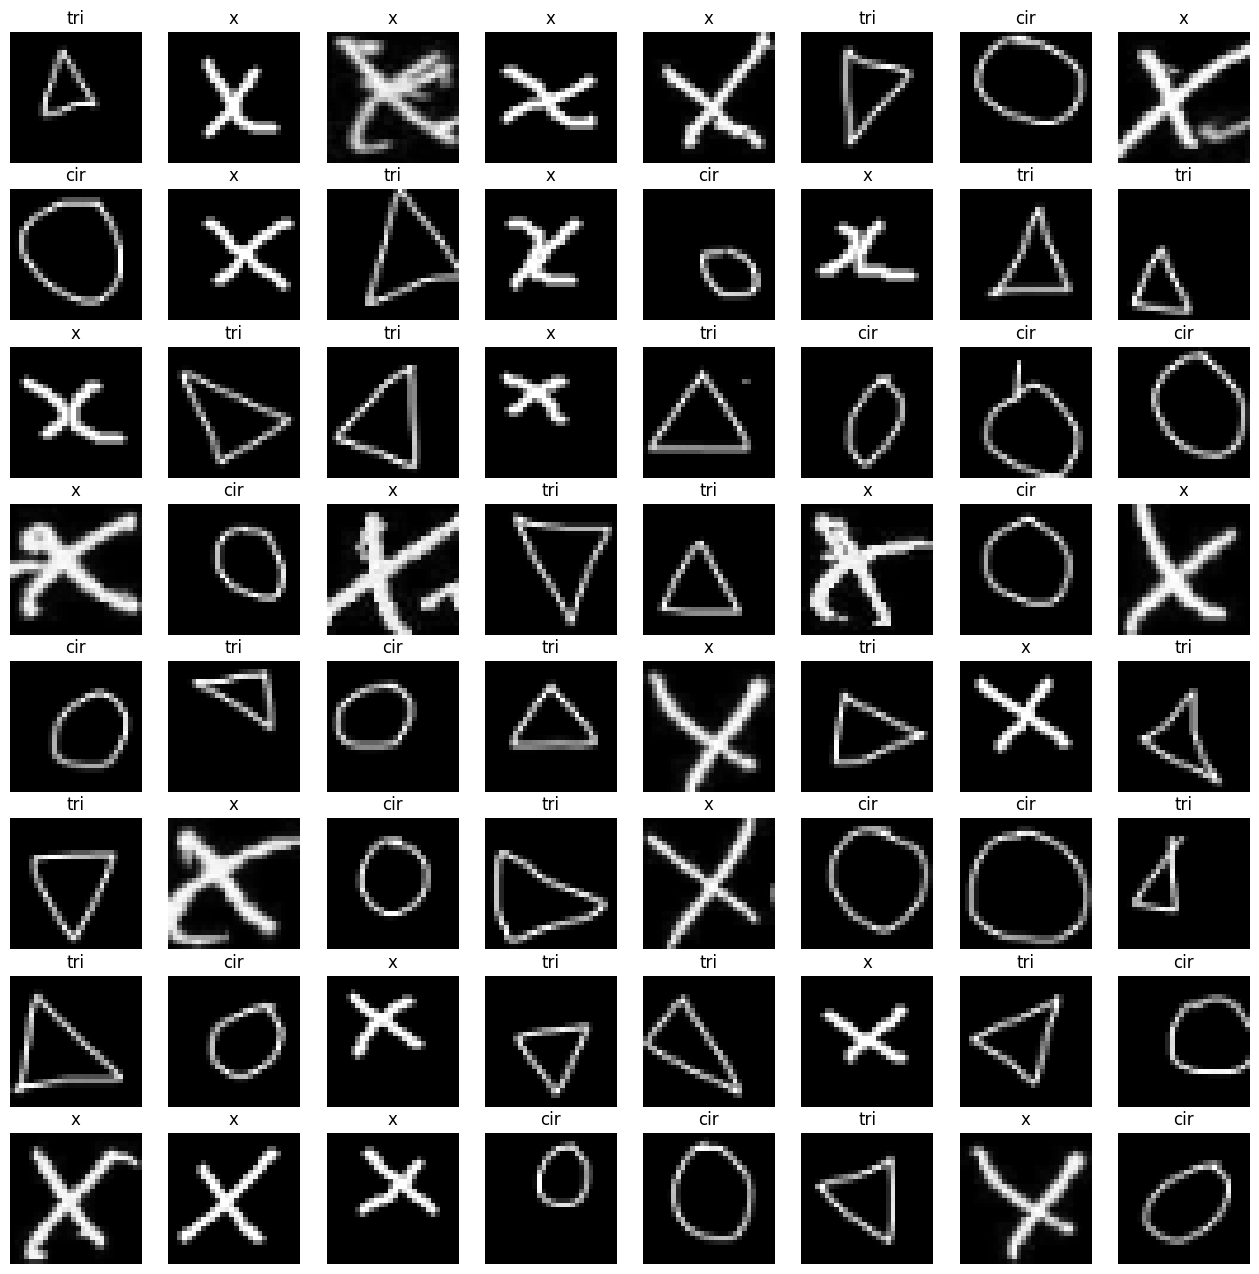

In [15]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [16]:
# 장치 확인
device = 'cuda' if torch.cuda. is_available() else 'cpu'
device

'cpu'

# **2. CNN모델 만들기**

**4. 모델 구현**
- nn.Module을 상속하여 새로운 네트워크 정의
- 기존 모델 수정 可
- 출력 클래스 수 조정 등 구조 변경

In [17]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self). __init__()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Conv2d(1, 28, kernel_size = 3, padding = 'same'),
            nn.ReLU(),

            nn.Conv2d(28, 28, kernel_size = 3, padding = 'same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(28, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.Conv2d(56, 56, kernel_size=3, padding='same'),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size = 2),
            nn.Dropout(0.25)
        )
        self.Linear = nn.Linear(56 * 7 * 7, 3)

    def forward(self, x):
        x = self.classifier(x)
        x = self.flatten(x)
        output = self.Linear(x)
        return output

In [18]:
model = ConvNeuralNetwork().to(device)
model

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)

**5. 손실함수, 옵티마이저 설정**
- 분류: CrossEntropyLoss, 회귀: MSELoss 등
- 옵티마이저: SGD, Adam, RMSprop 등 선택

In [19]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**6. 학습 함수 정의**
- train_model() 또는 fit() 함수 작성
- Epoch마다 loss, accuracy 계산 및 출력


In [20]:
# 학습 루프 함수: 평균 손실과 정확도 계산

def train_loop(train_loader, model, loss_fn, optimizer):
    sum_losses = 0
    sum_accs = 0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_losses = sum_losses + loss

        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc

    avg_loss = sum_losses / len(train_loader)
    avg_acc = sum_accs / len(train_loader)
    return avg_loss, avg_acc

In [21]:
epochs = 50

for i in range(epochs):
    print("------------------------------------------------------------------")
    avg_loss, avg_acc = train_loop(loader, model, loss, optimizer)
    print(f'Epoch {i:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')
print("Done!")



------------------------------------------------------------------
Epoch    0/50 Loss: 1.099492 Accuracy: 29.95%
------------------------------------------------------------------
Epoch    1/50 Loss: 1.040200 Accuracy: 46.88%
------------------------------------------------------------------
Epoch    2/50 Loss: 0.800950 Accuracy: 70.83%
------------------------------------------------------------------
Epoch    3/50 Loss: 0.510179 Accuracy: 72.27%
------------------------------------------------------------------
Epoch    4/50 Loss: 0.395855 Accuracy: 80.60%
------------------------------------------------------------------
Epoch    5/50 Loss: 0.327489 Accuracy: 80.73%
------------------------------------------------------------------
Epoch    6/50 Loss: 0.308537 Accuracy: 83.07%
------------------------------------------------------------------
Epoch    7/50 Loss: 0.303635 Accuracy: 86.07%
------------------------------------------------------------------
Epoch    8/50 Loss: 0.249779 

**7. 모델 평가**
- 검증셋 및 테스트셋에 대한 정확도 측정
- Confusion Matrix, 시각화 등


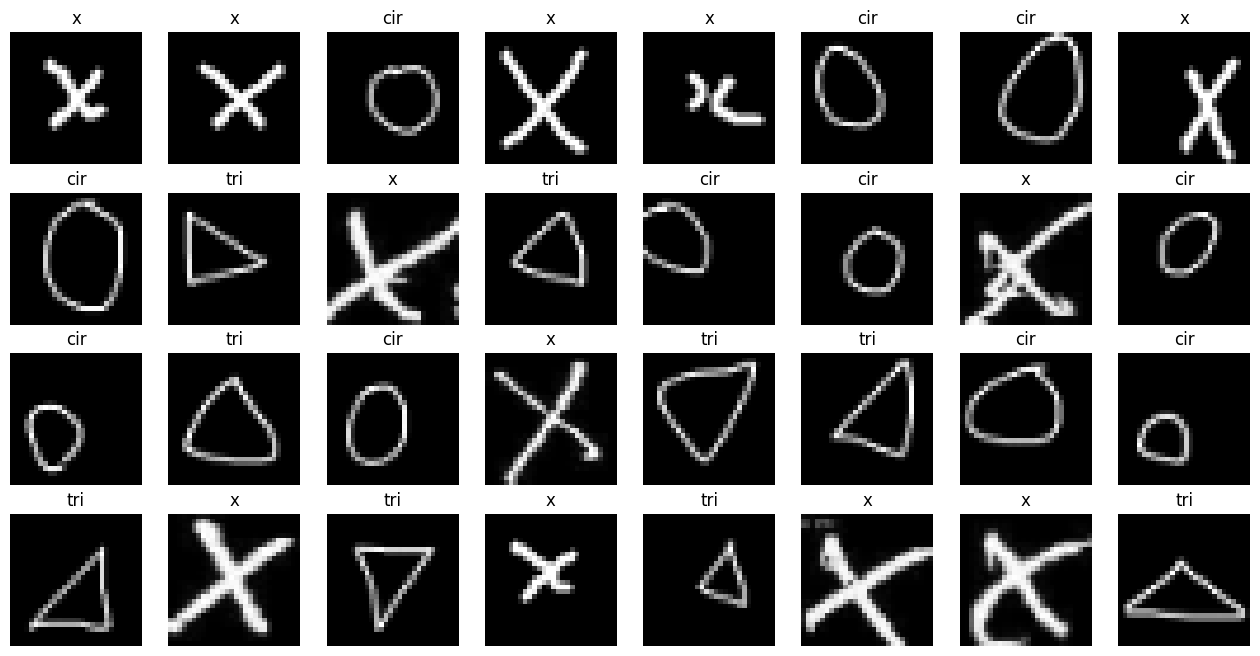

In [22]:
# 테스트 데이터 로드
test_loader = DataLoader(
    dataset=testset,
    batch_size=32,
    shuffle=True
)

imgs, labels = next(iter(test_loader))
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.reshape(28, 28), cmap='gray')
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [23]:
# 테스트 데이터셋을 통해 모델의 성능을 평가하고, 예측 결과, 정답 레이블, 입력 이미지, 평균 정확도를 반환
def test(model, loader):
    model.eval()
    sum_accs = 0
    img_list = torch.Tensor().to(device)
    y_pred_list = torch.Tensor().to(device)
    y_true_list = torch.Tensor().to(device)

    for x_batch, y_batch in loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        y_pred_list = torch.cat((y_pred_list, y_pred_index), dim=0)
        y_true_list = torch.cat((y_true_list, y_batch), dim=0)
        img_list = torch.cat((img_list, x_batch), dim=0)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs += acc

    avg_acc = sum_accs / len(loader)
    return y_pred_list, y_true_list, img_list, avg_acc

In [24]:
y_pred_list, y_true_list, img_list, avg_acc = test(model, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 79.46% 입니다.


**8. 결과 시각화**

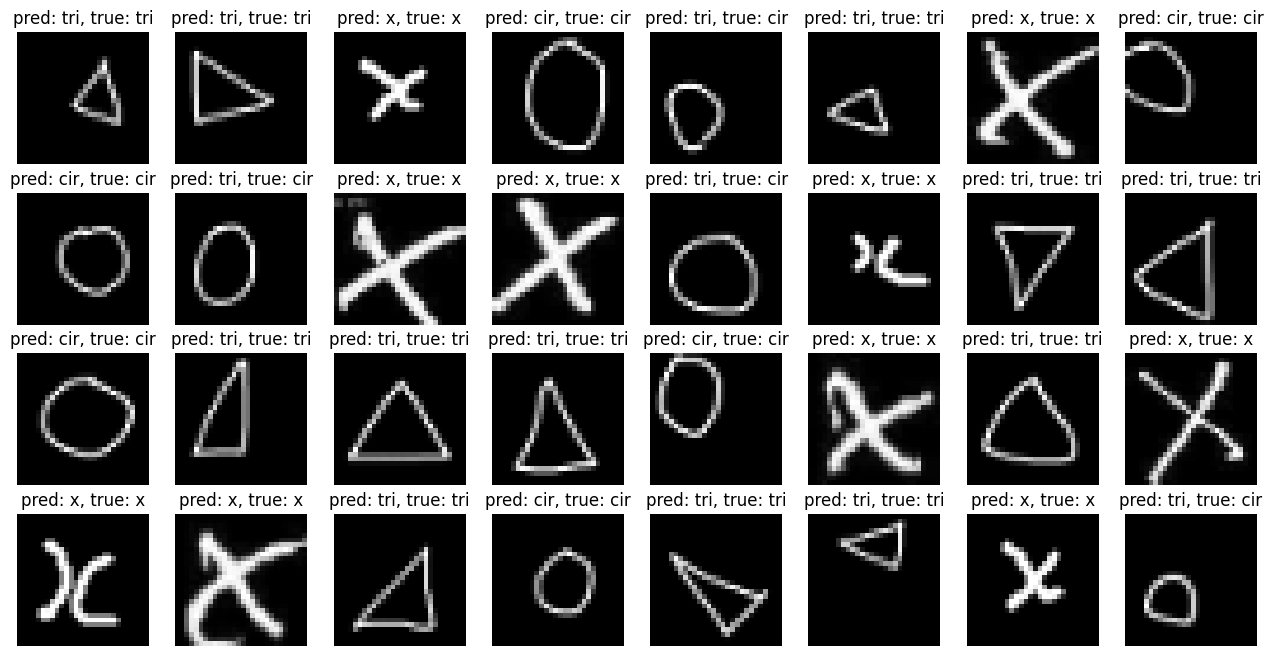

In [25]:
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

img_list_cpu = img_list.cpu()
y_pred_list_cpu = y_pred_list.cpu()
y_true_list_cpu = y_true_list.cpu()

for ax, img, y_pred, y_true in zip(axes.flatten(), img_list_cpu, y_pred_list_cpu, y_true_list_cpu):
  ax.imshow(img.reshape(28, 28), cmap='gray')
  ax.set_title(f'pred: {class_map[y_pred.item()]}, true: {class_map[y_true.item()]}')
  ax.axis('off')

plt.show()

# **3. 모델 저장하고 불러오기**

### (1) 모델의 가중치와 매개변수만 저장


모델의 구조가 저장되지 않으므로 모델 클래스 정의가 없으면 복원할 수 없다.

**9. 저장**

In [26]:
torch.save(model.state_dict(), 'model_weight.pth')

In [27]:
model2 = ConvNeuralNetwork().to(device)
model2

ConvNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Conv2d(1, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(28, 28, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.25, inplace=False)
  )
  (Linear): Linear(in_features=2744, out_features=3, bias=True)
)

In [28]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

# 껍데기만 테스트함.

테스트 정확도는 33.48% 입니다.


In [29]:
model2.load_state_dict(torch.load('model_weight.pth'))

<All keys matched successfully>

In [30]:
y_pred_list, y_true_list, img_list, avg_acc = test(model2, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

테스트 정확도는 79.46% 입니다.


### (2) 모델 전체를 저장

모델 클래스와 가중치가 함께 저장되므로, 복원 시 모델 구조를 별도로 정의할 필요 없음

In [31]:
torch.save(model, 'model.pth')

In [32]:
model3 = torch.load('model.pth', weights_only = False)

In [33]:
y_pred_list, y_true_list, img_list, avg_acc = test(model3, test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}% 입니다.')

# 모델을 통째로 저장하고, 통째로 불러오는 방법

테스트 정확도는 79.69% 입니다.
